# Comparison of dependency relations in evaluation

In this notebook, we will look closer at how different classes of dependency relations affect the evaluation results for each language. We will mainly be interested in the absolute precision and recall for each label class, and comparing their score to the overall labeled attachment score in each language.

We will be using the parsing results from __running Maltparser with the default settings__, where 19 languages from UD 1.1 where trained with Mate tools. 

Maltparser uses all available morphological features, if there are any available. Therefore, German, French, and Spanish might be affected negatively since they lack morphological features in the training data. At least for UD 1.1. I couldn't find this data for version 1.0, so there might be even more languages lacking feature data.

The classes to be analyzed are:

#### Functional and content dependents
As specified in [A manual classification of dependency relations](/notebooks/A%20manual%20classification%20of%20dependency%20relations.ipynb)

- Functional dependents
- Content dependendents

#### Dependent classes as specified in the [UD documentation](http://universaldependencies.github.io/docs/u/dep/index.html)

- Classes expected to perform better than overall LAS for __synthetic__ languages:
  - __Core dependents of clausal predicates__: nsubj, csubj, nsubjpass, csubjpass, dobj, ccomp, xcomp, iobj
  - __Non-core dependents of clausal predicates__: nmod, advcl, advmod, neg
  - __Noun dependents, excluding _det_ and _neg___: nummod, acl, amod, appos, nmod
  - __Coordination, excluding _cc_ and _punct___: conj
  - 
- Classes expected to perform better than overall LAS for __isolated__ languages:
  - __Special clausal dependents__: vocative, aux, mark, discourse, auxpass, punct, expl, cop
  - __Case-marking, prepositions, possessive__: case


## Things to keep in mind when looking at the results

- Irish and Hungarian has fairly little data, and can't probably be trusted. 
- Czech has A LOT of data.

In [17]:
# My classes
content_dependents = ("acl", "advcl", "advmod", "amod", "appos", "ccomp", "compound", "conj", "csubj", "csubjpass", "dislocated", "dobj", "iobj", "list", "name", "nmod", "nsubj", "nsubjpass", "nummod", "parataxis", "remnant", "root", "vocative", "xcomp")
function_dependents = ('aux', 'auxpass', 'case', 'cc', 'cop', 'det', 'expl', 'mark', 'neg', 'mwe')
nonsemantic_dependents = ("punct", "discourse", "reparandum", "dep", "goeswith", "foreign")

# UD classes
core_dependents = ['nsubj', 'csubj', 'nsubjpass', 'csubjpass', 'dobj', 'ccomp', 'xcomp', 'iobj']
noncore_dependents = ['nmod', 'advcl', 'advmod', 'neg']
noun_dependents = ['nummod', 'acl', 'amod', 'appos', 'nmod']
coordination_dependents = ['conj']
special_clausal_dependents = ['vocative', 'aux', 'mark', 'discourse', 'auxpass', 'expl', 'cop']
other_functional_dependents = ['det', 'cc', 'case', 'mwe']

all_labels = content_dependents + function_dependents + nonsemantic_dependents + ("ROOT",)

In [18]:
%matplotlib inline
import matplotlib
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 7.0)
matplotlib.style.use('ggplot')

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

import sys, os
from os.path import join
sys.path.append("../tools/")
import udeval

import pandas as pd
import seaborn as sns
from collections import defaultdict

system_output_path = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/maltparser_output/"
gold_output_path = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/universaldependencies1-1/ud-treebanks-v1.1/"

system_output = {"UD_Basque": "UD_Basque.conllx",
                "UD_Croatian": "UD_Croatian.conllx",
                "UD_Danish": "UD_Danish.conllx",
                "UD_Finnish": "UD_Finnish.conllx",
                "UD_French": "UD_French.conllx",
                "UD_Greek": "UD_Greek.conllx",
                "UD_Hungarian": "UD_Hungarian.conllx",
                "UD_Irish": "UD_Irish.conllx",
                "UD_Persian": "UD_Persian.conllx",
                "UD_Swedish": "UD_Swedish.conllx",
                "UD_Bulgarian": "UD_Bulgarian.conllx",
                "UD_Czech": "UD_Czech.conllx",
                "UD_English": "UD_English.conllx",
                "UD_Finnish-FTB": "UD_Finnish-FTB.conllx",
                "UD_German": "UD_German.conllx",
                "UD_Hebrew": "UD_Hebrew.conllx",
                "UD_Indonesian": "UD_Indonesian.conllx",
                "UD_Italian": "UD_Italian.conllx",
                "UD_Spanish": "UD_Spanish.conllx"}

gold_file = {'UD_Basque': 'eu-ud-test.conllu',
            'UD_Croatian': 'hr-ud-test.conllu',
            'UD_Danish': 'da-ud-test.conllu',
            'UD_Finnish': 'fi-ud-test.conllu',
            'UD_French': 'fr-ud-test.conllu',
            'UD_Greek': 'el-ud-test.conllu',
            'UD_Hungarian': 'hu-ud-test.conllu',
            'UD_Irish': 'ga-ud-test.conllu',
            'UD_Persian': 'fa-ud-test.conllu',
            'UD_Swedish': 'sv-ud-test.conllu',
            'UD_Bulgarian': 'bg-ud-test.conllu',
            'UD_Czech': 'cs-ud-test.conllu',
            'UD_English': 'en-ud-test.conllu',
            'UD_Finnish-FTB': 'fi_ftb-ud-test.conllu',
            'UD_German': 'de-ud-test.conllu',
            'UD_Hebrew': 'he-ud-test.conllu',
            'UD_Indonesian': 'id-ud-test.conllu',
            'UD_Italian': 'it-ud-test.conllu',
            'UD_Spanish': 'es-ud-test.conllu'}

In [19]:
def labeled_attachment_scores():
    las = {}
    for lang in system_output.keys():
        s_out =  join(system_output_path, system_output[lang])
        g_out = join(gold_output_path, lang, gold_file[lang])
        score = udeval.attachment_score(s_out, g_out, labeled=True)
        las[lang] = score
    return pd.Series(las)
        
def precision_recall_filter_labels(labels):
    prec_recs = {"precision": [], "recall": []}
    index = []
    for lang in system_output.keys():
        s_out =  join(system_output_path, system_output[lang])
        g_out = join(gold_output_path, lang, gold_file[lang])
        precision, recall = udeval.labels_precision_recall(s_out, 
                                                           g_out, 
                                                           labels=labels)
        index.append(lang)
        prec_recs["precision"].append(precision)
        prec_recs["recall"].append(recall)

    return pd.DataFrame(prec_recs, index=index).sort_values("precision")

In [20]:
labeled_attachment_scores()

UD_Basque         0.231615
UD_Bulgarian      0.836466
UD_Croatian       0.355879
UD_Czech          0.768428
UD_Danish         0.274607
UD_English        0.796900
UD_Finnish        0.593545
UD_Finnish-FTB    0.784620
UD_French         0.488628
UD_German         0.252634
UD_Greek          0.719654
UD_Hebrew         0.562392
UD_Hungarian      0.206239
UD_Indonesian     0.408744
UD_Irish          0.624967
UD_Italian        0.823576
UD_Persian        0.645238
UD_Spanish        0.439358
UD_Swedish        0.753840
dtype: float64

In [21]:
all_labels_results = precision_recall_filter_labels(all_labels)
all_labels_results

,precision,recall
UD_Hungarian,0.206239,0.206239
UD_Basque,0.231615,0.231615
UD_German,0.252634,0.252634
UD_Danish,0.274607,0.274607
UD_Croatian,0.355879,0.355879
UD_Indonesian,0.408744,0.408744
UD_Spanish,0.439358,0.439358
UD_French,0.488628,0.488628
UD_Hebrew,0.563274,0.563274
UD_Finnish,0.593545,0.593545


In [6]:
label_result = dict()
for label in all_labels:
    label_result[label] = precision_recall_filter_labels([label])

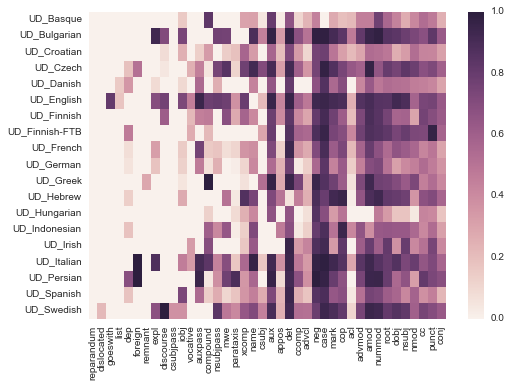

In [7]:
# Sort precision heatmap with languages according to standard ttr, 
# dependency labels according to cross-language entropy
dep_entropy = pd.Series.from_csv('../data/crosslingual_dependency_entropy.csv').index
dep_entropy = [label for label in dep_entropy if label != "subj"]  # remove hebrew bug
#sttr = ["fi", "cs", "de", "hu", "fr", "es", "ga", "sv", "it", "en"]
labels_precision = pd.DataFrame({y:x['precision'] for y,x in label_result.items()})
absolute_precision_scores = labels_precision[dep_entropy].fillna(0)
sns.heatmap(absolute_precision_scores)

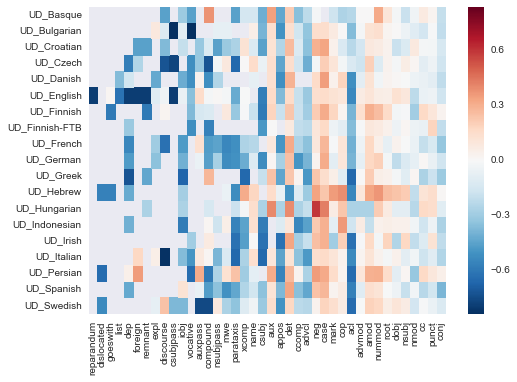

In [8]:
relative_precision_scores = labels_precision.subtract(all_labels_results['precision'], axis=0)[dep_entropy]
sns.heatmap(relative_precision_scores);

__TODO__: Analysis

# Performance for dependency classes

We calculate the precision and recall only using the labels classified as content relations. We then subtract the LAS to present how large of an increase (or reduction) in results the label class gets.

### Content and function relations

#### Absolute performance

In [9]:
content_dependents_result = precision_recall_filter_labels(content_dependents)
function_dependents_result = precision_recall_filter_labels(function_dependents)
results_dict = {"Content dependents": content_dependents_result, 
                "Function dependents": function_dependents_result}

content_function_results = pd.concat(results_dict.values(), keys=results_dict.keys(), axis=1)
content_function_results

Content dependents           Function dependents          
                        precision    recall           precision    recall
UD_Basque                0.398779  0.398779            0.622971  0.622971
UD_Bulgarian             0.791043  0.791043            0.931362  0.931362
UD_Croatian              0.409216  0.409216            0.593361  0.593361
UD_Czech                 0.753339  0.753339            0.864760  0.864760
UD_Danish                0.470268  0.470268            0.718071  0.718071
UD_English               0.746540  0.746540            0.918169  0.918169
UD_Finnish               0.535358  0.535358            0.765752  0.765752
UD_Finnish-FTB           0.749862  0.749862            0.795517  0.795517
UD_French                0.532062  0.532062            0.787468  0.787468
UD_German                0.424062  0.424062            0.716500  0.716500
UD_Greek                 0.661760  0.661760            0.862240  0.862240
UD_Hebrew                0.562171  0.562171            0.542353  0.542353
UD_Hungarian             0.120115  0.120115            0.601739  0.601739
UD_Indonesian            0.553164  0.553164            0.738448  0.738448
UD_Irish                 0.509208  0.509208            0.787589  0.787589
UD_Italian               0.751934  0.751934            0.934180  0.934180
UD_Persian               0.529140  0.529140            0.882340  0.882340
UD_Spanish               0.492605  0.492605            0.805638  0.805638
UD_Swedish               0.700817  0.700817            0.863404  0.863404

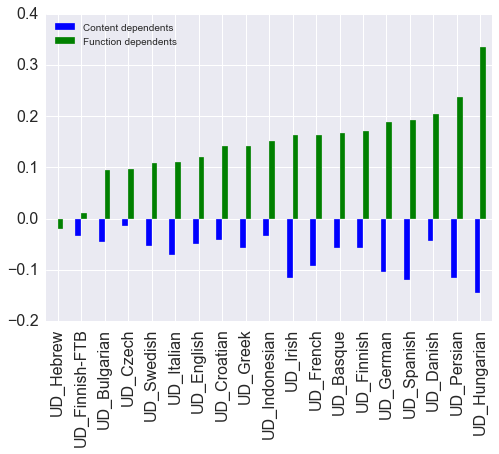

In [10]:
content_function_precisions = content_function_results.subtract(all_labels_results, level=1).xs('precision', level=1, axis=1)
content_function_precisions.sort_values('Function dependents').plot(kind='bar', fontsize=16)

In [11]:
core_dependent_result = precision_recall_filter_labels(core_dependents)
noncore_dependents_result = precision_recall_filter_labels(noncore_dependents)
noun_dependents_result = precision_recall_filter_labels(noun_dependents)
coordination_dependents_result = precision_recall_filter_labels(coordination_dependents)
special_clausal_dependents_result = precision_recall_filter_labels(special_clausal_dependents)
other_functional_dependents_result = precision_recall_filter_labels(other_functional_dependents)

ud_result_dict = {'Core': core_dependent_result,
                  'Noncore': noncore_dependents_result,
                  'Noun': noun_dependents_result,
                  'Coordination': coordination_dependents_result,
                  'Special clausal': special_clausal_dependents_result,
                  'Functionals': other_functional_dependents_result}

ud_class_result = pd.concat(ud_result_dict.values(), keys=ud_result_dict.keys(), axis=1)
ud_class_result

Noun           Special clausal                Core  \
               precision    recall       precision    recall precision   
UD_Basque       0.439455  0.439455        0.656011  0.656011  0.315861   
UD_Bulgarian    0.809328  0.809328        0.916071  0.916071  0.773453   
UD_Croatian     0.493421  0.493421        0.434783  0.434783  0.322957   
UD_Czech        0.822648  0.822648        0.779788  0.779788  0.778506   
UD_Danish       0.485139  0.485139        0.596273  0.596273  0.500561   
UD_English      0.647849  0.647849        0.909273  0.909273  0.864437   
UD_Finnish      0.430346  0.430346        0.699115  0.699115  0.563984   
UD_Finnish-FTB  0.759564  0.759564        0.742955  0.742955  0.752052   
UD_French       0.561947  0.561947        0.644944  0.644944  0.583144   
UD_German       0.510689  0.510689        0.521383  0.521383  0.324832   
UD_Greek        0.720930  0.720930        0.843407  0.843407  0.619824   
UD_Hebrew       0.461248  0.461248        0.875706  0.875706  0.708891   
UD_Hungarian    0.055138  0.055138        0.400000  0.400000  0.162242   
UD_Indonesian   0.513174  0.513174        0.674603  0.674603  0.543440   
UD_Irish        0.431579  0.431579        0.437008  0.437008  0.468278   
UD_Italian      0.778137  0.778137        0.904033  0.904033  0.726638   
UD_Persian      0.474642  0.474642        0.778667  0.778667  0.632164   
UD_Spanish      0.543597  0.543597        0.668359  0.668359  0.502959   
UD_Swedish      0.641780  0.641780        0.866155  0.866155  0.796551   

                           Noncore           Functionals            \
                  recall precision    recall   precision    recall   
UD_Basque       0.315861  0.393698  0.393698    0.589681  0.589681   
UD_Bulgarian    0.773453  0.751675  0.751675    0.930849  0.930849   
UD_Croatian     0.322957  0.487898  0.487898    0.672474  0.672474   
UD_Czech        0.778506  0.717169  0.717169    0.891724  0.891724   
UD_Danish       0.500561  0.462585  0.462585    0.782422  0.782422   
UD_English      0.864437  0.667158  0.667158    0.915817  0.915817   
UD_Finnish      0.563984  0.424857  0.424857    0.803347  0.803347   
UD_Finnish-FTB  0.752052  0.740157  0.740157    0.825272  0.825272   
UD_French       0.583144  0.565982  0.565982    0.818474  0.818474   
UD_German       0.324832  0.446732  0.446732    0.771922  0.771922   
UD_Greek        0.619824  0.709395  0.709395    0.864228  0.864228   
UD_Hebrew       0.708891  0.404934  0.404934    0.487264  0.487264   
UD_Hungarian    0.162242  0.064915  0.064915    0.608961  0.608961   
UD_Indonesian   0.543440  0.555942  0.555942    0.744784  0.744784   
UD_Irish        0.468278  0.463450  0.463450    0.874745  0.874745   
UD_Italian      0.726638  0.780411  0.780411    0.937787  0.937787   
UD_Persian      0.632164  0.370345  0.370345    0.915188  0.915188   
UD_Spanish      0.502959  0.556811  0.556811    0.834077  0.834077   
UD_Swedish      0.796551  0.647336  0.647336    0.865343  0.865343   

               Coordination            
                  precision    recall  
UD_Basque          0.259184  0.259184  
UD_Bulgarian       0.628842  0.628842  
UD_Croatian        0.313433  0.313433  
UD_Czech           0.599750  0.599750  
UD_Danish          0.301370  0.301370  
UD_English         0.630184  0.630184  
UD_Finnish         0.624528  0.624528  
UD_Finnish-FTB     0.579186  0.579186  
UD_French          0.301724  0.301724  
UD_German          0.364326  0.364326  
UD_Greek           0.415888  0.415888  
UD_Hebrew          0.570815  0.570815  
UD_Hungarian       0.173913  0.173913  
UD_Indonesian      0.318898  0.318898  
UD_Irish           0.414634  0.414634  
UD_Italian         0.574176  0.574176  
UD_Persian         0.693512  0.693512  
UD_Spanish         0.227273  0.227273  
UD_Swedish         0.632458  0.632458

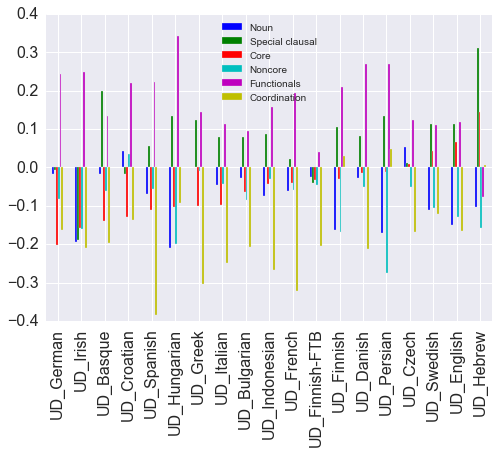

In [12]:
relative_ud_class_result = ud_class_result.subtract(all_labels_results, level=1).xs('precision', level=1, axis=1)
relative_ud_class_result.sort_values('Core').plot(kind='bar', fontsize=16)

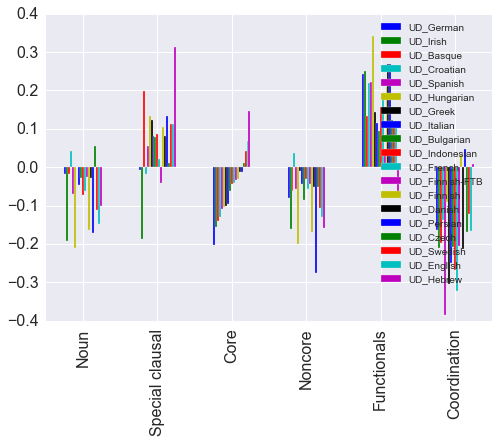

In [13]:
relative_ud_class_result.sort_values("Core").transpose().plot(kind='bar', fontsize=16)

In [14]:
add_order = [('core', core_dependents), 
             ('noun', noun_dependents), 
             ('non_core', noncore_dependents), 
             ('coord', coordination_dependents), 
             ('specl', special_clausal_dependents),
             ('functionals', other_functional_dependents)]


labels = []
cumul_results = []
cumul_name = ""
for class_name, label_class in add_order:
    labels += label_class
    labels_result = precision_recall_filter_labels(labels)
    cumul_name += "+" + class_name
    cumul_results.append((cumul_name, labels_result))

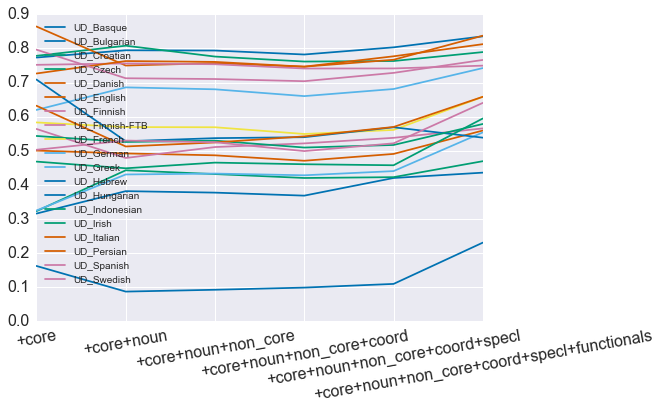

In [15]:
cmap1 = mpl.colors.ListedColormap(sns.color_palette("colorblind", 10))
pd.DataFrame([x[1]['precision'] for x in cumul_results], index=[x[0] for x in cumul_results]).plot(rot=10, fontsize=16, cmap=cmap1)

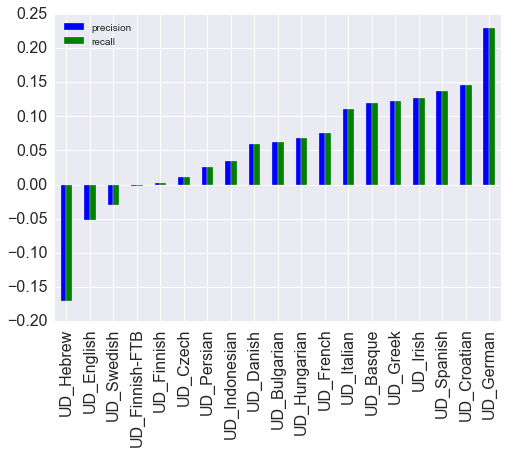

In [16]:
(cumul_results[-1][1] - cumul_results[0][1]).sort_values("precision").plot(kind='bar', fontsize=16)